In [15]:
%load_ext watermark
%watermark -p tensorflow,skimage,matplotlib,numpy,random


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from random import shuffle
from tqdm import tqdm

import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

from keras.models import load_model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
tensorflow 1.7.0
skimage 0.13.1
matplotlib 2.2.2
numpy 1.14.2
random n


In [2]:
# loading the data with the help of https://www.datacamp.com/community/tutorials/tensorflow-tutorial#tensors
# and https://pythonprogramming.net/convolutional-neural-network-kats-vs-dogs-machine-learning-tutorial/

def get_label(x):
    return {
        'n0': 0,
        'n1': 1,
        'n2': 2,
        'n3': 3,
        'n4': 4,
        'n5': 5,
        'n6': 6,
        'n7': 7,
        'n8': 8,
        'n9': 9,
    }[x]


def load_data(data_directory, saveName):
    # take the subdirectories of monkeys
    subdirs = [subdir for subdir in os.listdir(data_directory)
                   if os.path.isdir(os.path.join(data_directory, subdir))]
    
    prepare_data =[]
    for subdir in tqdm(subdirs):
        class_directory = os.path.join(data_directory, subdir)
        file_names= [os.path.join(class_directory, file) for file in os.listdir(class_directory)]
        for file in file_names:
            image= data.imread(file, as_grey=True)
            image= transform.resize(image, (256, 256))
            label = get_label(subdir)
            prepare_data.append([np.array(image), label])
    
    shuffle(prepare_data)
    name = saveName +'.npy'
    np.save(name, prepare_data)
   
    return prepare_data


In [16]:
train_dir = '../monkeyDataset/training'
validate_dir = '../monkeyDataset/validation'

cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("../monkeyDataset/monkey_labels.txt", names=cols, skiprows=1)
print(labels)

   Label                Latin Name                      Common Name  \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

   Train Images  Validation Images  
0           131                 26  
1           139                 28  
2           137                 27  
3           152                 30  
4           131                 2

In [17]:
train_dir = '../monkeyDataset/training'
validate_dir = '../monkeyDataset/validation'

train_data_generator = ImageDataGenerator(rescale=1./255)
train_generator = train_data_generator.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=20, class_mode="categorical")

val_data_generator = ImageDataGenerator(rescale=1./255)
val_generator = val_data_generator.flow_from_directory(
    validate_dir, target_size=(150,150), batch_size=20, class_mode="categorical")


Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [18]:
def build_convnet():
    network = Sequential()
    network.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(64, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(512, activation="relu"))
    network.add(Dense(10, activation="softmax"))
    network.compile(optimizer=RMSprop(lr=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])
    return network

In [19]:
network = build_convnet()
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [20]:
history = network.fit_generator(
    train_generator, steps_per_epoch=100, epochs=30,
    validation_data=val_generator, validation_steps=50,
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)],
    verbose=0)

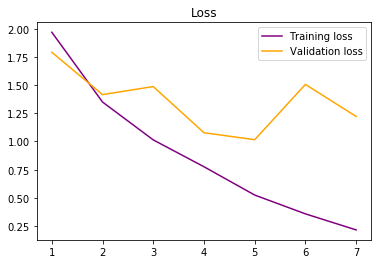

In [23]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

x_vals = range(1, 8)
fig = plt.figure()
plt.title("Loss")
plt.plot(x_vals, train_loss, label="Training loss", color = "purple")
plt.plot(x_vals, val_loss, label="Validation loss", color = "orange")
plt.legend()
plt.show()

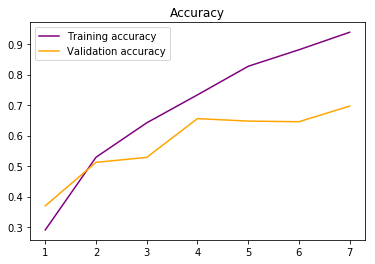

In [24]:
train_acc = history.history["acc"]
val_acc = history.history["val_acc"]

fig = plt.figure()
plt.title("Accuracy")
plt.plot(x_vals, train_acc, label="Training accuracy", color = "purple")
plt.plot(x_vals, val_acc, label="Validation accuracy", color = "orange")
plt.legend()
plt.show()

In [25]:
# Since patience was 2, perhaps display the metrics from just before that point
train_loss = history.history["loss"][-3]
val_loss = history.history["val_loss"][-3]
train_acc = history.history["acc"][-3]
val_acc = history.history["val_acc"][-3]

print("Train loss=",train_loss)
print("Validation loss=",val_loss)
print("Train accuracy=", train_acc)
print("Validation accuracy", val_acc)

Train loss= 0.524979982317422
Validation loss= 1.0158501123307182
Train accuracy= 0.8272225010760282
Validation accuracy 0.6475409838508387
